# Facilitated Machine Learning Models for Karyotyping in the Patients with Chromosomal Abnormalities: Retrospective Study

- **Chuan Yang**, MD, PhD Student
- Mentor: **Yanyan Zhao**, MD, PhD
- Shengjing Hospital of China Medical University

# Chr 09 vs Chr 09 Inversion

# 0. Modules

In [1]:
from PIL import Image
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import seaborn as sb

from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from sklearn.model_selection import KFold

from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten
from tensorflow import keras

from os import walk

import time
import datetime

%matplotlib inline

# 1. Samples


## 1.1. Chormosome Label Convert by using Dictionary

In [2]:
chromConvert = {
               'chr_09': 0, 
               'chr_9_inversion': 1
               }

In [3]:
chromConvert_reverse = {
                0: 'chr_09',
                1: 'chr_9_inversion'
               }

## 1.2. File Import

### 1.2.1. Filename Assignments

In [4]:
# pathBase = 'C:\\Users\\Chuan\\OneDrive\\Dowrun\\Database\\PhD\\KaryoTypes\\Arrangement\\'
# pathBase = 'I:\\Chuan\\Documents\\MyData\\PhD\\Karyotype\\Arrangement\\'
# pathBase = 'D:\\Users\\Chuan\\Documents\\Database\\Karyotypes\\Arrangement\\'
# ///////////////////////////////////////////////
# Merged Database
#pathBase = 'D:\\Users\\Chuan\\Documents\\Database\\Karyotypes\\Arrangement_Merged\\'

pathBase = 'I:\\Chuan\\Documents\\MyData\\PhD\\Karyotype\\Arrangement_Merged\\'

theWhole = {}
        
f = []
f_09 = []
mypath_09 = pathBase + 'chr_09'
for (dirpath, dirnames, filenames) in walk(mypath_09):
    f.extend(filenames)
for l in f:
    f_09.append(mypath_09 + '\\' + l)    
    
# ///////// Abnormal ones //////////////

f = []
f_9_inversion = []
mypath_9_inversion = pathBase + 'chr_9_inversion'
for (dirpath, dirnames, filenames) in walk(mypath_9_inversion):
    f.extend(filenames)
for l in f:
    f_9_inversion.append(mypath_9_inversion + '\\' + l)  
    
theWhole['chr_09'] = f_09
theWhole['chr_9_inversion'] = f_9_inversion


In [5]:
theWhole['chr_9_inversion']

['I:\\Chuan\\Documents\\MyData\\PhD\\Karyotype\\Arrangement_Merged\\chr_9_inversion\\193002-9p12q13_11R.bmp',
 'I:\\Chuan\\Documents\\MyData\\PhD\\Karyotype\\Arrangement_Merged\\chr_9_inversion\\193002-9p12q13_12R.bmp',
 'I:\\Chuan\\Documents\\MyData\\PhD\\Karyotype\\Arrangement_Merged\\chr_9_inversion\\193002-9p12q13_13R.bmp',
 'I:\\Chuan\\Documents\\MyData\\PhD\\Karyotype\\Arrangement_Merged\\chr_9_inversion\\193002-9p12q13_14R.bmp',
 'I:\\Chuan\\Documents\\MyData\\PhD\\Karyotype\\Arrangement_Merged\\chr_9_inversion\\193002-9p12q13_15R.bmp',
 'I:\\Chuan\\Documents\\MyData\\PhD\\Karyotype\\Arrangement_Merged\\chr_9_inversion\\193002-9p12q13_16R.bmp',
 'I:\\Chuan\\Documents\\MyData\\PhD\\Karyotype\\Arrangement_Merged\\chr_9_inversion\\193002-9p12q13_17R.bmp',
 'I:\\Chuan\\Documents\\MyData\\PhD\\Karyotype\\Arrangement_Merged\\chr_9_inversion\\193002-9p12q13_18R.bmp',
 'I:\\Chuan\\Documents\\MyData\\PhD\\Karyotype\\Arrangement_Merged\\chr_9_inversion\\193002-9p12q13_19R.bmp',
 'I:\\Chua

In [6]:
type(theWhole['chr_09'])

list

In [7]:
len(theWhole)

2

In [8]:
type(theWhole)

dict

In [9]:
theWhole.keys()

dict_keys(['chr_09', 'chr_9_inversion'])

### 1.2.2. Helper Functions

In [10]:
def extractData(image):
    x = image.size[0]
    y = image.size[1]
    
    matrix = []
    rgb_matrix = []

    for i in range(x):
        matrix.append([])
        rgb_matrix.append([])
        
        for j in range(y):
            r, g, b = image.getpixel((j, i))            
            value = r * 299.0/1000 + g * 587.0/1000 + b * 114.0/1000
            value = int(value)
            matrix[i].append(value)
            rgb_matrix[i].append((r,g,b))
    return matrix, rgb_matrix

In [11]:
def imageReconstruct(matrix):
    df = np.array(matrix, dtype=np.uint8)
    img = Image.fromarray(df, 'RGB')
    img.save('image.png')
    return img

# 2. Cross Validation

## 2.1. KFold

- Let's say split every class into 7 folds

In [12]:
kfold = KFold(7, True, 1)

# 分成7个子集，每次6个子集用于训练，1个子集用于测试
# 每种分法进行一次训练和测试的迭代，总共8次迭代。

## 2.2. Assignment of filename which has been splitted randomly

In [13]:
X_train_name = {}
X_test_name = {}

# 赋值两个接收文件路径的dictionary，其第一个key值为染色体或异常核型的名称，第二个为交叉验证（迭代）的序号

for chrNo in theWhole.keys():

    X_train_name[chrNo] = {}
    X_test_name[chrNo] = {}
    
    # chrNo为染色体号或异常核型号，在此内部再定义迭代次数

    split_method_number = 0
    
    # 赋值每次split分法的序号值

    generator_kFold = kfold.split(theWhole[chrNo])
    
    # 依染色体或异常核型的类型进行split，因为每个类别的样本量不均衡，以每个类别进行split
    # 赋值一个generator对象，以下对generator进行迭代。
    
    print('Chromosome/Abnormality: ', chrNo)

    for train, test in generator_kFold:    
        
        # 循环产生train和test集

        print('Split Method No. ', split_method_number)

        print('Train: ', train, 'Test: ', test, '\n')

        # train和test的值是7个split分法的每个分法的list

        X_train_name[chrNo][split_method_number] = []
        X_test_name[chrNo][split_method_number] = []




        for split_method_train in train:
            
            # train 为训练集list中的序号值

            # split_method_train的值是每个split方法，其值为图像序号
            
            X_train_name[chrNo][split_method_number].append(theWhole[chrNo][split_method_train])
            
            # 将训练集那个序号的图像的文件path和文件名赋值给X_train_name这个二维dictionary


        for split_method_test in test:

            # split_method_test的值是每个split方法，其值为图像序号
            
            X_test_name[chrNo][split_method_number].append(theWhole[chrNo][split_method_test])
            
            # 同样将测试集的路径和文件名赋值给X_test_name

        split_method_number = split_method_number + 1
        
        # Split分法序号自加

Chromosome/Abnormality:  chr_09
Split Method No.  0
Train:  [  0   1   2   3   5   6   7   8   9  10  11  13  14  15  16  17  18  19
  20  21  22  23  24  25  26  28  29  30  31  32  33  35  36  37  40  41
  42  43  45  46  47  48  49  50  52  53  54  55  56  57  59  60  61  63
  64  65  66  67  68  69  70  71  72  74  75  76  77  79  80  81  82  83
  84  86  87  88  89  91  92  93  94  95  96  97  98  99 100 101 103 104
 105 108 109 110 111 112 113 115 118 119 120 121 122 124 125 126 128 129
 130 131 132 133 134 135 136 137 138 139 141 142 143 144 145 146 147 148
 149 150 151 152 153 154 155 156 157 158 159 160 161 162 163 164 165 166
 167 168 169 170 171 172 174 175 176 177 178 179 180 181 182 183 184 185
 187 188 189 191 192 193 196 197 198 199 200 201 202 203 204 205 206 207
 208 209 210 211 212 213 214 215 216 217 218 220 221 222 224 225 226 227
 228 229 230 231 234 235 236 237 238 239 240 241 242 243 244 246 247 248
 250 253 254 255 256 258] Test:  [  4  12  27  34  38  39  44  5

In [14]:
len(X_train_name['chr_09'])

7

In [15]:
len(X_train_name['chr_09'][0])

222

In [16]:
len(X_test_name['chr_09'][0])

38

In [17]:
X_train_name['chr_09'][1] # 表示第一轮split的方法的1号染色体的训练样本的文件名

['I:\\Chuan\\Documents\\MyData\\PhD\\Karyotype\\Arrangement_Merged\\chr_09\\193002-9p12q13_12L.bmp',
 'I:\\Chuan\\Documents\\MyData\\PhD\\Karyotype\\Arrangement_Merged\\chr_09\\193002-9p12q13_13L.bmp',
 'I:\\Chuan\\Documents\\MyData\\PhD\\Karyotype\\Arrangement_Merged\\chr_09\\193002-9p12q13_14L.bmp',
 'I:\\Chuan\\Documents\\MyData\\PhD\\Karyotype\\Arrangement_Merged\\chr_09\\193002-9p12q13_15L.bmp',
 'I:\\Chuan\\Documents\\MyData\\PhD\\Karyotype\\Arrangement_Merged\\chr_09\\193002-9p12q13_16L.bmp',
 'I:\\Chuan\\Documents\\MyData\\PhD\\Karyotype\\Arrangement_Merged\\chr_09\\193002-9p12q13_17L.bmp',
 'I:\\Chuan\\Documents\\MyData\\PhD\\Karyotype\\Arrangement_Merged\\chr_09\\193002-9p12q13_18L.bmp',
 'I:\\Chuan\\Documents\\MyData\\PhD\\Karyotype\\Arrangement_Merged\\chr_09\\193002-9p12q13_19L.bmp',
 'I:\\Chuan\\Documents\\MyData\\PhD\\Karyotype\\Arrangement_Merged\\chr_09\\193002-9p12q13_1L.bmp',
 'I:\\Chuan\\Documents\\MyData\\PhD\\Karyotype\\Arrangement_Merged\\chr_09\\193002-9p12q13_2

In [18]:
X_test_name['chr_09'][1]

['I:\\Chuan\\Documents\\MyData\\PhD\\Karyotype\\Arrangement_Merged\\chr_09\\193002-9p12q13_11L.bmp',
 'I:\\Chuan\\Documents\\MyData\\PhD\\Karyotype\\Arrangement_Merged\\chr_09\\193002-9p12q13_2L.bmp',
 'I:\\Chuan\\Documents\\MyData\\PhD\\Karyotype\\Arrangement_Merged\\chr_09\\193002-9p12q13_7L.bmp',
 'I:\\Chuan\\Documents\\MyData\\PhD\\Karyotype\\Arrangement_Merged\\chr_09\\193002-9p12q13_9L.bmp',
 'I:\\Chuan\\Documents\\MyData\\PhD\\Karyotype\\Arrangement_Merged\\chr_09\\W07391-9p12q_10L.bmp',
 'I:\\Chuan\\Documents\\MyData\\PhD\\Karyotype\\Arrangement_Merged\\chr_09\\W07391-9p12q_19L.bmp',
 'I:\\Chuan\\Documents\\MyData\\PhD\\Karyotype\\Arrangement_Merged\\chr_09\\W07391-9p12q_1L.bmp',
 'I:\\Chuan\\Documents\\MyData\\PhD\\Karyotype\\Arrangement_Merged\\chr_09\\W07391-9p12q_21L.bmp',
 'I:\\Chuan\\Documents\\MyData\\PhD\\Karyotype\\Arrangement_Merged\\chr_09\\W07391-9p12q_2L.bmp',
 'I:\\Chuan\\Documents\\MyData\\PhD\\Karyotype\\Arrangement_Merged\\chr_09\\W07391-9p12q_4L.bmp',
 'I:\\Ch

In [19]:
X_train_name

{'chr_09': {0: ['I:\\Chuan\\Documents\\MyData\\PhD\\Karyotype\\Arrangement_Merged\\chr_09\\193002-9p12q13_11L.bmp',
   'I:\\Chuan\\Documents\\MyData\\PhD\\Karyotype\\Arrangement_Merged\\chr_09\\193002-9p12q13_12L.bmp',
   'I:\\Chuan\\Documents\\MyData\\PhD\\Karyotype\\Arrangement_Merged\\chr_09\\193002-9p12q13_13L.bmp',
   'I:\\Chuan\\Documents\\MyData\\PhD\\Karyotype\\Arrangement_Merged\\chr_09\\193002-9p12q13_14L.bmp',
   'I:\\Chuan\\Documents\\MyData\\PhD\\Karyotype\\Arrangement_Merged\\chr_09\\193002-9p12q13_16L.bmp',
   'I:\\Chuan\\Documents\\MyData\\PhD\\Karyotype\\Arrangement_Merged\\chr_09\\193002-9p12q13_17L.bmp',
   'I:\\Chuan\\Documents\\MyData\\PhD\\Karyotype\\Arrangement_Merged\\chr_09\\193002-9p12q13_18L.bmp',
   'I:\\Chuan\\Documents\\MyData\\PhD\\Karyotype\\Arrangement_Merged\\chr_09\\193002-9p12q13_19L.bmp',
   'I:\\Chuan\\Documents\\MyData\\PhD\\Karyotype\\Arrangement_Merged\\chr_09\\193002-9p12q13_1L.bmp',
   'I:\\Chuan\\Documents\\MyData\\PhD\\Karyotype\\Arrangement

# Iteration Starts Here:

###  Performance variables defined for iterations

In [20]:
iterationNumber = 0
accuracies = {}
performanceReport = {}
auc_value_dict = {}

# 3. Iteration 0

## 3.1 Image Input

### 3.1.x Display the Split Method

In [21]:
print('Iteration No. ', iterationNumber)


for chrNo in theWhole.keys():
    print(chrNo)
    print('   Train: ')
    for item in X_train_name[chrNo][iterationNumber]:
        print('       ', item.split('\\')[-1])
    print('   Test: ')
    for item in X_test_name[chrNo][iterationNumber]:
        print('       ', item.split('\\')[-1])

Iteration No.  0
chr_09
   Train: 
        193002-9p12q13_11L.bmp
        193002-9p12q13_12L.bmp
        193002-9p12q13_13L.bmp
        193002-9p12q13_14L.bmp
        193002-9p12q13_16L.bmp
        193002-9p12q13_17L.bmp
        193002-9p12q13_18L.bmp
        193002-9p12q13_19L.bmp
        193002-9p12q13_1L.bmp
        193002-9p12q13_24L.bmp
        193002-9p12q13_2L.bmp
        193002-9p12q13_4L.bmp
        193002-9p12q13_5L.bmp
        193002-9p12q13_6L.bmp
        193002-9p12q13_7L.bmp
        193002-9p12q13_8L.bmp
        193002-9p12q13_9L.bmp
        W07391-9p12q_10L.bmp
        W07391-9p12q_11L.bmp
        W07391-9p12q_12L.bmp
        W07391-9p12q_13L.bmp
        W07391-9p12q_14L.bmp
        W07391-9p12q_15L.bmp
        W07391-9p12q_16L.bmp
        W07391-9p12q_17L.bmp
        W07391-9p12q_19L.bmp
        W07391-9p12q_1L.bmp
        W07391-9p12q_20L.bmp
        W07391-9p12q_21L.bmp
        W07391-9p12q_22L.bmp
        W07391-9p12q_2L.bmp
        W07391-9p12q_4L.bmp
        W07391

### 3.1.2. Assignment of Training Data

#### 3.1.2.1 Training: Image Object Assignment

In [22]:
image = {}

# 定义容纳图片对象的dictionary类型的变量image

i = 0

for chrNo in theWhole.keys():
    image[chrNo] = []
    for case in X_train_name[chrNo][iterationNumber]:
        
        # 上面一行第二个中括号内为split的序号，0为第0次split分法
        
        img = Image.open(case)
        image[chrNo].append(img)
        
        # image字典接受的是图片对象

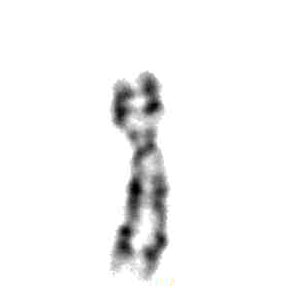

In [23]:
image['chr_09'][1] # 测试一下图像对象

#### 3.1.2.2. Training: Data Extraction from Images

#### - Training Set Data: 将图像对象转变为矩阵数值

In [24]:
data = {}
#rgb_data = {}

for chrNo in image.keys():
    data[chrNo] = []; 
    #rgb_data[chrNo] = []
    for case in image[chrNo]:
        grey, rgb = extractData(case)
        data[chrNo].append(grey)
        #rgb_data[chrNo].append(rgb)

In [25]:
array = {}

for chrNo in data.keys():
    array[chrNo] = []
    for case in data[chrNo]:            
        array[chrNo].append(case)

x_train_list = []
y_train_list = []

for y, x in array.items():    
    for x_item in x:
        x_train_list.append(x_item)
        y_train_list.append(y)
        
        # 将图像数据赋值给x_train_list;
        # 将标签数据赋值给y_train_list.

### 3.1.3. Assignment of Testing Data

#### 3.1.3.1. Testing: Image Object Assignment

In [26]:
# 方法同前面的Training Set

image = {}
i = 0

for chrNo in theWhole.keys():
    image[chrNo] = []
    for case in X_test_name[chrNo][iterationNumber]: # Change here for different iterations!!!!!
        
        # 上面一行第二个中括号内为split的序号，0为第0次split分法
        
        img = Image.open(case)
        image[chrNo].append(img)

#### 3.1.3.2. Testing: Data Extraction from Images

In [27]:
data = {}
#rgb_data = {}

for chrNo in image.keys():
    data[chrNo] = []; 
    #rgb_data[chrNo] = []
    for case in image[chrNo]:
        grey, rgb = extractData(case)
        data[chrNo].append(grey)
        #rgb_data[chrNo].append(rgb)

In [28]:
array = {}

for chrNo in data.keys():
    array[chrNo] = []
    for case in data[chrNo]:            
        array[chrNo].append(case)

x_test_list = []
y_test_list = []

for y, x in array.items():    
    for x_item in x:
        x_test_list.append(x_item)
        y_test_list.append(y)

### 3.1.4. ChromConvert

In [29]:
# 将染色体序号和异常核型名称更换为序号，序号定义在程序开始部分

y_train_digital_list = []
for item in y_train_list:
    y_train_digital_list.append(chromConvert[item])
    
y_test_digital_list = []
for item in y_test_list:
    y_test_digital_list.append(chromConvert[item])

### 3.1.5. Change to Numpy Array

In [30]:
X_train = np.array(x_train_list)
y_train = np.array(y_train_digital_list)

In [31]:
X_test = np.array(x_test_list)
y_test = np.array(y_test_digital_list)

In [32]:
y_test

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [33]:
len(X_train)

370

In [34]:
X_train[0].shape

(300, 300)

## 3.2. Convolutional Neural Network

### 3.2.1 Data Preparation

In [35]:
X_train = X_train.reshape(-1, 300, 300, 1)
X_test = X_test.reshape(-1, 300, 300, 1)

### 3.2.3 Training Model Design

In [36]:
model = Sequential()

In [37]:
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(300, 300, 1)))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))

In [38]:
model.add(Flatten())
model.add(Dense(300, activation='relu'))
model.add(Dense(400, activation='relu'))
model.add(Dense(500, activation='relu'))
model.add(Dense(600, activation='relu'))
model.add(Dense(800, activation='relu'))
model.add(Dense(1000, activation='relu'))
model.add(Dense(900, activation='relu'))
model.add(Dense(500, activation='relu'))
model.add(Dense(400, activation='relu'))
model.add(Dense(300, activation='relu'))
model.add(Dense(100, activation='relu'))
model.add(Dense(50, activation='relu'))
model.add(Dense(20, activation='relu'))
model.add(Dense(10, activation='relu'))
model.add(Dense(2, activation='sigmoid'))

### 3.2.4. Tensorboard Initilization

In [39]:
%load_ext tensorboard
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

### 3.2.5. Compile the modal

In [40]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

### 3.2.6. Fitting (拟合)

In [41]:
model.fit(X_train, y_train, epochs=30, batch_size=64, verbose=1, 
          validation_data=(X_test, y_test),
          callbacks=[tensorboard_callback])

Epoch 1/30
6/6 [==============================] - 20s 3s/step - loss: 40.6085 - accuracy: 0.4919 - val_loss: 0.7376 - val_accuracy: 0.6032
Epoch 2/30
6/6 [==============================] - 17s 3s/step - loss: 1.0793 - accuracy: 0.4865 - val_loss: 0.6725 - val_accuracy: 0.6032
Epoch 3/30
6/6 [==============================] - 17s 3s/step - loss: 0.6938 - accuracy: 0.6000 - val_loss: 0.6717 - val_accuracy: 0.6032
Epoch 4/30
6/6 [==============================] - 17s 3s/step - loss: 0.6901 - accuracy: 0.6000 - val_loss: 0.6915 - val_accuracy: 0.6032
Epoch 5/30
6/6 [==============================] - 17s 3s/step - loss: 0.6897 - accuracy: 0.5622 - val_loss: 0.6681 - val_accuracy: 0.6032
Epoch 6/30
6/6 [==============================] - 17s 3s/step - loss: 0.6747 - accuracy: 0.6000 - val_loss: 0.6660 - val_accuracy: 0.6032
Epoch 7/30
6/6 [==============================] - 17s 3s/step - loss: 0.5717 - accuracy: 0.6189 - val_loss: 0.4755 - val_accuracy: 0.7143
Epoch 8/30
6/6 [=================

### 3.2.7 Summary

In [42]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 298, 298, 32)      320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 149, 149, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 147, 147, 64)      18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 73, 73, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 71, 71, 64)        36928     
_________________________________________________________________
flatten (Flatten)            (None, 322624)            0         
_________________________________________________________________
dense (Dense)                (None, 300)               9

### 3.2.8. Tensorboard Display

In [43]:
%tensorboard --logdir logs/fit

Reusing TensorBoard on port 6006 (pid 23880), started 1 day, 5:45:06 ago. (Use '!kill 23880' to kill it.)

## 3.8 Save the Model

In [44]:
model.save('saved_model/model_Chr_09_cnn_iteration_'+str(iterationNumber))

INFO:tensorflow:Assets written to: saved_model/model_Chr_09_cnn_iteration_0\assets


## 3.9 Load the Model

In [45]:
model_reload = keras.models.load_model('saved_model/model_Chr_09_cnn_iteration_'+str(iterationNumber))

## 3.10. Performance Measures

### 3.10.1. Accuracy

In [46]:
loss, acc = model_reload.evaluate(X_test, y_test, verbose=0)
print('Test Accuracy: %.3f' % acc)
accuracies[iterationNumber] = acc

Test Accuracy: 0.937


In [47]:
len(X_test)

63

In [48]:
y_predict = model_reload.predict(X_test)

In [49]:
len(y_predict)

63

In [50]:
# The number 32 means the type number of all chromosome class number inlcuding abnormal ones
y_predict_filtered = []

for sample in y_predict:
    maximum = 0
    indicator = 0
    for i in range(2):
        if sample[i] > maximum:
            maximum = sample[i]
            indicator = i
    y_predict_filtered.append(indicator)        

In [51]:
label = ['chr_09', 'chr_9_inversion']

label_convert = []

for i in range(2):
    label_convert.append(chromConvert_reverse[i])

### 3.10.2. Classification Report

In [52]:
performanceReport[iterationNumber] = classification_report(y_test, y_predict_filtered, target_names=label_convert)

# Change here for different iteration!!!!!

print(performanceReport[iterationNumber])

                 precision    recall  f1-score   support

         chr_09       0.97      0.92      0.95        38
chr_9_inversion       0.89      0.96      0.92        25

      micro avg       0.94      0.94      0.94        63
      macro avg       0.93      0.94      0.93        63
   weighted avg       0.94      0.94      0.94        63



### 3.10.3. Confusion Matrix

In [53]:
cm = np.array(confusion_matrix(y_test, y_predict_filtered, labels=[0, 1]))
confusion = pd.DataFrame(cm, index=label_convert,
                        columns=label_convert)
confusion.to_csv('ConfusionMatrix_Chr_09_KaryoType_CNN' + str(iterationNumber) + '.csv')
confusion

,chr_09,chr_9_inversion
chr_09,35,3
chr_9_inversion,1,24


#### Heat Map

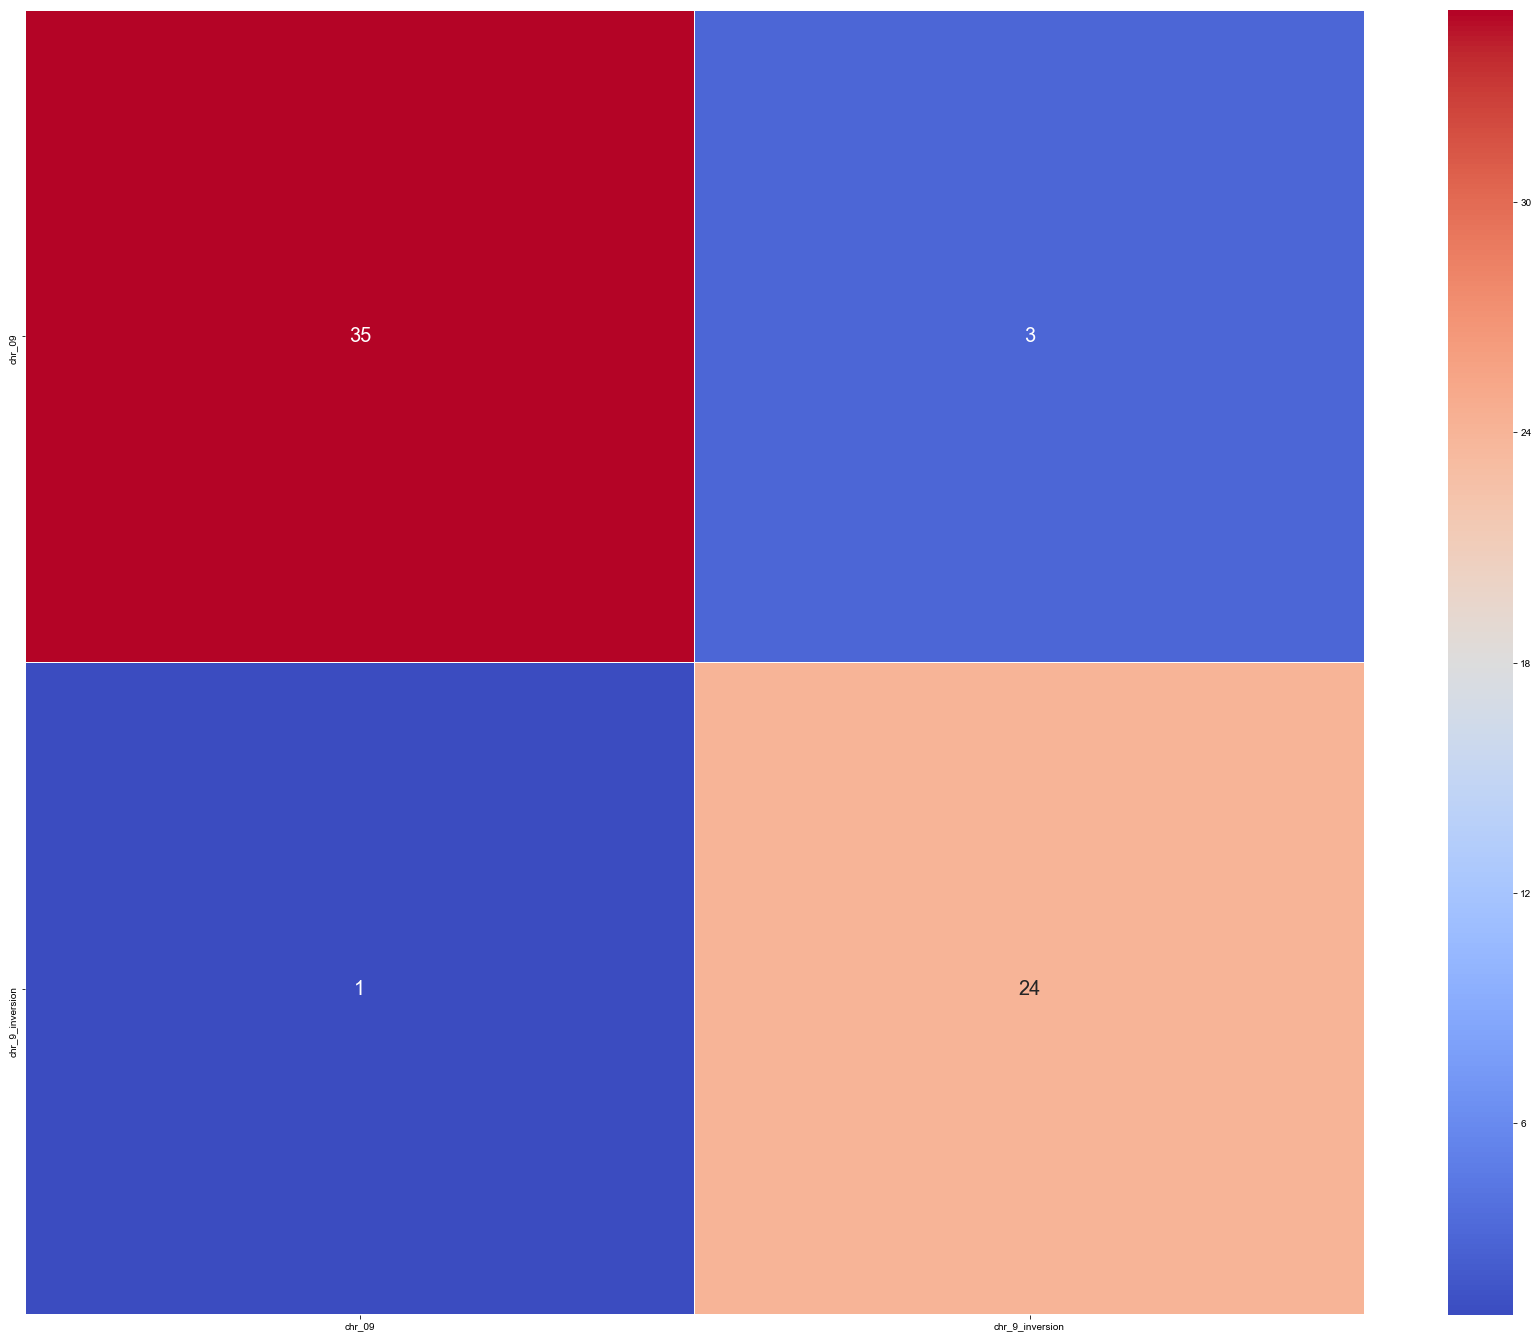

In [54]:
plt.figure(figsize=(30, 24))
heat_map = sb.heatmap(confusion, annot=True,  # It's a Seaborn function
                      cmap='coolwarm', 
                      xticklabels=confusion.columns, yticklabels=confusion.index, 
                      linewidths=.5, 
                      annot_kws={"size": 20})
sb.set(font_scale = 2)

In [55]:
fig = heat_map.get_figure()    
fig.savefig('Heatmap_Chr_09_Iteration_' + str(iterationNumber) + '.png', dpi=400)

### 3.10.4. ROC

In [56]:
y_predict

array([[0.99476993, 0.9848382 ],
       [1.        , 0.99999976],
       [0.999607  , 0.997349  ],
       [0.9999953 , 0.9999057 ],
       [0.9999796 , 0.99970734],
       [0.99999505, 0.9999007 ],
       [1.        , 1.        ],
       [1.        , 1.        ],
       [1.        , 1.        ],
       [1.        , 1.        ],
       [0.99996555, 0.99956536],
       [0.99999845, 0.9999574 ],
       [0.9999758 , 0.9996654 ],
       [0.99992764, 0.99924576],
       [1.        , 1.        ],
       [1.        , 0.9999969 ],
       [1.        , 0.99999905],
       [0.99999857, 0.9999598 ],
       [0.9999411 , 0.99935323],
       [1.        , 1.        ],
       [0.9999999 , 0.9999919 ],
       [1.        , 0.9999986 ],
       [0.9871458 , 0.9955214 ],
       [0.99999607, 0.9999139 ],
       [1.        , 1.        ],
       [0.99993956, 0.9999954 ],
       [1.        , 1.        ],
       [0.9999989 , 0.9999667 ],
       [1.        , 1.        ],
       [0.98622334, 0.97520494],
       [0.

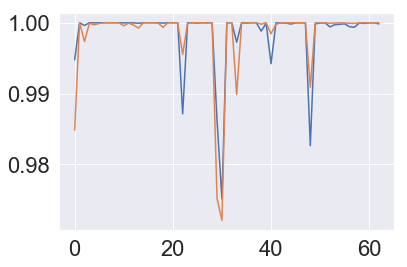

In [57]:
plt.plot(y_predict)

In [58]:
y_predict_1D = y_predict[:,1]

In [59]:
fpr , tpr , thresholds = roc_curve(y_test , y_predict_1D)
auc_rf = auc(fpr, tpr)

In [60]:
auc_rf

0.47263157894736846

In [61]:
x = y = np.arange(0,1.1,0.1)

In [62]:
x

array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ])

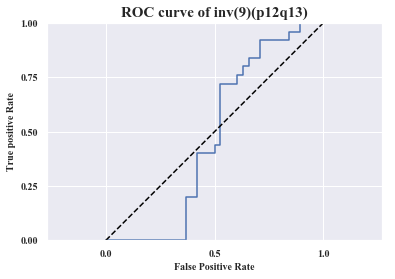

In [63]:
plt.plot(fpr, tpr)
plt.plot(x, y, '--', color='black')
plt.title('ROC curve of inv(9)(p12q13)', fontsize=15, fontname = 'Times New Roman')
plt.xlabel('False Positive Rate', fontsize=10, fontname = 'Times New Roman')
plt.ylabel('True positive Rate', fontsize=10, fontname = 'Times New Roman')
plt.axis('equal')
plt.xlim(0,1)
plt.ylim(0,1)
plt.xticks(fontsize=10, fontname = 'Times New Roman')
plt.yticks(fontsize=10, fontname = 'Times New Roman')

plt.savefig('ROC_Curve_Chr_09_' + str(iterationNumber) + '.png', dpi=400)
plt.show()

#### 3.10.4.1 AUC Value

In [64]:
auc_value = auc(fpr, tpr)
auc_value_dict[iterationNumber] = auc_value

In [65]:
print('AUC is ', auc_value)

AUC is  0.47263157894736846


In [66]:
iterationNumber = iterationNumber + 1